In [1]:
import altair as alt
import json
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")
matplotlib.rcParams['figure.figsize'] = (12, 6)

In [6]:
gpx_files = !ls *.gpx
gpx_files

['2020-07-12 10-46-30.gpx',
 '2020-07-19 11-48-40.gpx',
 '2020-08-01 10-36-41.gpx',
 '2020-08-09 10-24-30.gpx',
 '2020-09-19 14-23-30.gpx',
 '2021-05-16 12-41-00.gpx']

In [8]:
import gpxpy

START_STOP = {
    '2020-07-12 10-46-30.gpx': {'start': '2020-07-12 10:46:30', 'stop': '2020-07-12 11:31:37'},
    '2020-07-19 11-48-40.gpx': {'start': '2020-07-19 11:48:40', 'stop': '2020-07-19 13:04:30'},
    '2020-08-01 10-36-41.gpx': {'start': '2020-08-01 10:36:41', 'stop': '2020-08-01 13:03:40'},
    '2020-08-09 10-24-30.gpx': {'start': '2020-08-09 10:24:30', 'stop': '2020-08-09 11:21:50'},
    '2020-09-19 14-23-30.gpx': {'start': '2020-09-19 14:23:30', 'stop': '2020-09-19 15:39:59'},
    '2021-05-16 12-41-00.gpx': {'start': '2021-05-16 12:41:00', 'stop': '2021-05-16 14:54:03'}
}

def parse_gpx(file_name):
    gpx = gpxpy.parse(open(file_name, 'r'))
    points = gpx.tracks[0].segments[0].points
    
    parsed = {}
    for i in range(1, len(points)):
        parsed[i] = {}
        parsed[i]['time'] = points[i].time
        parsed[i]['latitude'] = points[i].latitude
        parsed[i]['longitude'] = points[i].longitude
        parsed[i]['elevation'] = points[i].elevation
        parsed[i]['speed'] = points[i - 1].speed_between(points[i])
        parsed[i]['course'] = points[i - 1].course_between(points[i])
    parsed = pd.DataFrame(parsed).T.infer_objects()
    parsed.time = parsed.time.dt.tz_localize(None)
    parsed = parsed.set_index('time')

    parsed = parsed.resample('s').mean().interpolate()

    parsed['speed_smooth'] = parsed.rolling(30).mean().speed
    parsed['course_smooth'] = parsed.rolling(5).mean().course
    parsed['speed_knots'] = parsed.speed * 3.6 / 1.852
    parsed['speed_smooth_knots'] = parsed.speed_smooth * 3.6 / 1.852
    
    if file_name in START_STOP:
        parsed = parsed[START_STOP[file_name]['start']:START_STOP[file_name]['stop']]
    
    parsed.index = parsed.index.map(lambda t: t.strftime('%Y-%m-%dT%H:%M:%SZ'))
    
    return parsed

for g in gpx_files:
    print(g)
    df = parse_gpx(g)
    if g in START_STOP:
        df.to_csv(START_STOP[g]['start'].replace(':', '_') + '.csv')
    else:
        df.to_csv(g[:-4] + '.csv')

2020-07-12 10-46-30.gpx
2020-07-19 11-48-40.gpx
2020-08-01 10-36-41.gpx
2020-08-09 10-24-30.gpx
2020-09-19 14-23-30.gpx
2021-05-16 12-41-00.gpx


In [9]:
!ls -l *.csv

-rw-r--r-- 1 markus markus  505933 May 29 09:52 '2020-07-12 10_46_30.csv'
-rw-r--r-- 1 markus markus  851126 May 29 09:52 '2020-07-19 11_48_40.csv'
-rw-r--r-- 1 markus markus 1664202 May 29 09:52 '2020-08-01 10_36_41.csv'
-rw-r--r-- 1 markus markus  645315 May 29 09:52 '2020-08-09 10_24_30.csv'
-rw-r--r-- 1 markus markus  857317 May 29 09:52 '2020-09-19 14_23_30.csv'
-rw-r--r-- 1 markus markus 1501900 May 29 09:52 '2021-05-16 12_41_00.csv'


In [10]:
# !rm -rf *.csv

<AxesSubplot:xlabel='time'>

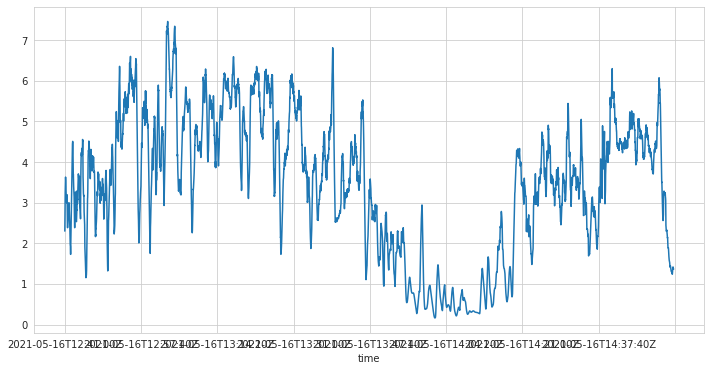

In [11]:
df.speed_smooth_knots.plot()

<AxesSubplot:xlabel='time'>

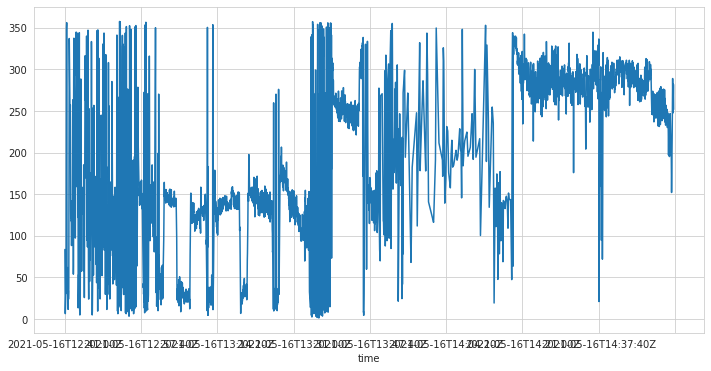

In [12]:
df.rolling(2).mean().course.plot()